## Import all libraries

In [1]:
import os, sys

# set the working directory
sys.path.append(os.getcwd()+ os.sep + ".." + os.sep + "..")

import pandas as pd
import pycaret.classification as pc
from imblearn.over_sampling import SMOTEN, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn import preprocessing
from sklearn.model_selection import  train_test_split

# import from ../script/data.py in scripts folder
from src.scripts.data import CR8_smoke_dict, OR45_dict, CR1_dict

define some functions

In [2]:
def read_dataframes(folder_path):
    file_list = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    file_list = file_list[2:]
    dataframes = {file: pd.read_csv(os.path.join(folder_path, file)) for file in file_list}
    return dataframes


def get_common_columns(dataframes):
    common_columns = dataframes[list(dataframes.keys())[0]].columns
    for df in dataframes.values():
        common_columns = common_columns.intersection(df.columns)
    return common_columns


def preprocess_dataframes(dataframes, common_columns):
    merged_df = pd.DataFrame()
    for i, (file, df) in enumerate(dataframes.items()):
        df = df[common_columns]
        # df.insert(0, "State", file.split(" ")[2])
        df.insert(0, "State", i)
        merged_df = pd.concat([merged_df, df])
    return merged_df

Import and preprocess data

In [65]:

# Read dataframes from GYTS folder
dataframes = read_dataframes("../../data/raw/GYTS/")

# Find common columns in all dataframes
common_columns = get_common_columns(dataframes)
print(common_columns)

# Preprocess dataframes
merged_df = preprocess_dataframes(dataframes, common_columns)


# Rename columns
merged_df.rename(columns={"CR1": "Age"}, inplace=True)
merged_df["Age"] = merged_df["Age"].map(CR1_dict)
merged_df.rename(columns={"CR2": "Gender"}, inplace=True)
merged_df["CR8"] = merged_df["CR8"].map(CR8_smoke_dict)
merged_df.rename(columns={"CR8": "Smoke"}, inplace=True)
merged_df.rename(columns={"OR45": "SmokingParents"}, inplace=True)
merged_df.rename(columns={"OR46": "SmokingFriends"}, inplace=True)
merged_df.rename(columns={"OR1": "WorkingParents"}, inplace=True)
merged_df.rename(columns={"CR22": "SeenSmokerInSchool"}, inplace=True)
merged_df.rename(columns={"CR21": "SeenSmokerInPublicPlace"}, inplace=True)
merged_df.rename(columns={"CR20": "SeenSmokerInEnclosedPlace"}, inplace=True)
merged_df.rename(columns={"CR19": "SeenSmokerInHome"}, inplace=True)
merged_df.rename(columns={"CR5": "TriedCigarette"}, inplace=True)
merged_df.rename(columns={"CR6": "AgeFirstCigarette"}, inplace=True)


# Keep only the desired columns
# merged_df = merged_df[["State", "Gender", "Age", "Smoke", "SmokingParents", "SmokingFriends", "WorkingParents",
#                        "SeenSmokerInSchool", "SeenSmokerInPublicPlace", "SeenSmokerInEnclosedPlace",
#                        "SeenSmokerInHome", "TriedCigarette", "AgeFirstCigarette"]]
merged_df = merged_df[["State", "Gender", "Age", "Smoke", "SmokingParents", "SmokingFriends", "WorkingParents",
                       "SeenSmokerInSchool", "SeenSmokerInPublicPlace", "SeenSmokerInEnclosedPlace",
                       "SeenSmokerInHome"]]
# merged_df = merged_df[["State", "Gender", "Age", "Smoke", "SmokingParents", "SmokingFriends", "WorkingParents"]]

# Drop rows with missing values
merged_df = merged_df.dropna()

merged_df['SmokingFather'] = merged_df['SmokingParents'].apply(lambda x: True if OR45_dict[x] in ['Both', 'Father only'] else False)
merged_df['SmokingMother'] = merged_df['SmokingParents'].apply(lambda x: True if OR45_dict[x] in ['Both', 'Mother only'] else False)
merged_df = merged_df.drop(columns=['SmokingParents'])

# Convert columns to categorical
merged_df['State'] = merged_df['State'].astype('int').astype('category')
merged_df["Gender"] = merged_df["Gender"].astype('int').astype('category')
# merged_df["Age"] = merged_df["Age"].astype('int').astype('category')
merged_df["Age"] = merged_df["Age"].astype('category')

merged_df["Smoke"] = merged_df["Smoke"].astype('int').astype('category')
#merged_df["SmokingParents"] = merged_df["SmokingParents"].astype('int').astype('category')
merged_df["SmokingFriends"] = merged_df["SmokingFriends"].astype('int').astype('category')
merged_df["WorkingParents"] = merged_df["WorkingParents"].astype('int').astype('category')
merged_df["SeenSmokerInSchool"] = merged_df["SeenSmokerInSchool"].astype('int').astype('category')
merged_df["SeenSmokerInPublicPlace"] = merged_df["SeenSmokerInPublicPlace"].astype('int').astype('category')
merged_df["SeenSmokerInEnclosedPlace"] = merged_df["SeenSmokerInEnclosedPlace"].astype('int').astype('category')
merged_df["SeenSmokerInHome"] = merged_df["SeenSmokerInHome"].astype('int').astype('category')
# merged_df["TriedCigarette"] = merged_df["TriedCigarette"].astype('category')
# merged_df["AgeFirstCigarette"] = merged_df["AgeFirstCigarette"].astype('category')

# Convert to boolean
merged_df['SmokingFather'] = merged_df['SmokingFather'].astype('bool')
merged_df['SmokingMother'] = merged_df['SmokingMother'].astype('bool')

# Save the preprocessed dataframe to a CSV file
merged_df.to_csv("../../data/processed/merged_GYTS.csv", index=False)


# Remove the 17 and older age group
# merged_df = merged_df[merged_df["Age"] != "17 years old or older"]

merged_df

Index(['FinalWgt', 'Stratum', 'PSU', 'CR1', 'CR2', 'CR5', 'CR6', 'CR7', 'CR8',
       'CR9', 'CR10', 'CR11', 'CR12', 'CR13', 'CR15', 'CR16', 'CR17', 'CR18',
       'CR19', 'CR20', 'CR21', 'CR22', 'CR23', 'CR25', 'CR30', 'CR31', 'CR32',
       'CR33', 'OR57', 'CR35', 'CR36', 'CR41', 'CR42', 'CR43', 'OR1', 'OR45',
       'OR46', 'OR49', 'OR55'],
      dtype='object')


,State,Gender,Age,Smoke,SmokingFriends,WorkingParents,SeenSmokerInSchool,SeenSmokerInPublicPlace,SeenSmokerInEnclosedPlace,SeenSmokerInHome,SmokingFather,SmokingMother
49,0,2,15 years old,1,1,2,2,2,2,1,True,True
51,0,2,15 years old,1,2,3,2,2,2,1,False,False
55,0,1,14 years old,0,1,2,2,3,2,1,True,True
111,0,2,15 years old,1,2,2,2,3,2,1,True,True
122,0,1,14 years old,1,2,3,2,3,2,2,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
1674,3,2,13 years old,0,3,3,2,5,1,1,False,False
1675,3,2,13 years old,0,2,3,2,3,1,2,False,False
1677,3,1,13 years old,0,4,3,1,3,2,2,False,False
1678,3,1,13 years old,0,2,3,1,1,1,2,True,False


Train and test model

In [64]:
# # Correlation matrix
# corr = merged_df_encoded.corr()
# fig, ax = plt.subplots(figsize=(40, 30))
# sns.heatmap(corr, annot=True, annot_kws={"size": 8}, linewidths=.5, ax=ax)
# plt.savefig("./data/processed/correlation_matrix.svg")
# # plt.show()

# Split the data into train and test sets
train, test = train_test_split(merged_df, test_size=0.2, random_state=42)
test.reset_index(drop=True, inplace=True)

# Split the train set into features and target
X = train.drop(columns=["Smoke"])
y = train["Smoke"]

# Convert y values to categorical values
lab = preprocessing.LabelEncoder()
y = lab.fit_transform(y)

No Sampling

In [ ]:
y = pd.DataFrame(y, columns=["Smoke"])
y.reset_index(drop=True, inplace=True)
X.reset_index(drop=True, inplace=True)
train = pd.concat([X, y] , axis=1)

Sampling

In [ ]:
# SMOTE Oversampling
smote = SMOTEN()
# smote = ADASYN()
# smote = RandomUnderSampler()
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert array to dataframe
y_resampled = pd.DataFrame(y_resampled, columns=['Smoke'])
# y = pd.DataFrame(y, columns=['Smoke'])

# remove index
# X.reset_index(drop=True, inplace=True)
# y.reset_index(drop=True, inplace=True)
X_resampled.reset_index(drop=True, inplace=True)

train = pd.concat([X_resampled, y_resampled], axis=1)
# df_resampled = pd.concat([X, y], axis=1)

Comparing models

In [66]:
# setup = pc.setup(data=train,
#                  target='Smoke',
#                  session_id=123,
#                  normalize=True,
#                  transformation=True,

#                  remove_multicollinearity=True, multicollinearity_threshold=0.95, max_encoding_ohe=0)

# merged_df.reset_index(drop=True, inplace=True)

X = merged_df.drop(columns=["Smoke"])
y = merged_df["Smoke"]

# Convert y values to categorical values
lab = preprocessing.LabelEncoder()
y = lab.fit_transform(y)

y = pd.DataFrame(y, columns=["Smoke"])
y.reset_index(drop=True, inplace=True)
X.reset_index(drop=True, inplace=True)
merged_df = pd.concat([X, y], axis=1)

setup = pc.setup(data=merged_df,
                 target='Smoke',
                 index=False,
                 session_id=123,
                #  normalize=True,
                #  encoding_method=preprocessing.LabelEncoder()
                ordinal_features={
                    "SmokingFriends" : [1, 2, 3, 4],
                    "SeenSmokerInSchool" : [1, 2],
                    "SeenSmokerInPublicPlace" : [1, 2, 3, 4, 5],
                    "SeenSmokerInEnclosedPlace" : [1, 2, 3, 4, 5],
                    "SeenSmokerInHome" : [1, 2, 3, 4, 5]
                    },
                #  fix_imbalance=True, fix_imbalance_method=SMOTEN(),
                 transformation=True,
                 remove_multicollinearity=True, multicollinearity_threshold=0.95,
                #  max_encoding_ohe=0
                )

best = pc.compare_models(sort='MCC')

,Description,Value
0,Session id,123
1,Target,Smoke
2,Target type,Binary
3,Original data shape,"(20368, 12)"
4,Transformed data shape,"(20368, 40)"
5,Transformed train set shape,"(14257, 40)"
6,Transformed test set shape,"(6111, 40)"
7,Ordinal features,5
8,Categorical features,9
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.8843,0.0000,0.4392,0.5380,0.4834,0.4190,0.4218,0.2960
nb,Naive Bayes,0.8042,0.0000,0.7165,0.3552,0.4747,0.3709,0.4055,0.2650
gbc,Gradient Boosting Classifier,0.8923,0.0000,0.3085,0.6300,0.4136,0.3620,0.3904,0.4800
ada,Ada Boost Classifier,0.8911,0.0000,0.3085,0.6175,0.4108,0.3583,0.3848,0.3800
lr,Logistic Regression,0.8919,0.0000,0.2875,0.6385,0.3957,0.3457,0.3794,1.6440
lightgbm,Light Gradient Boosting Machine,0.8893,0.0000,0.3102,0.6000,0.4086,0.3544,0.3781,0.5540
ridge,Ridge Classifier,0.8916,0.0000,0.2523,0.6609,0.3644,0.3180,0.3628,0.2690
xgboost,Extreme Gradient Boosting,0.8825,0.0000,0.3216,0.5397,0.4024,0.3421,0.3564,0.3630
knn,K Neighbors Classifier,0.8773,0.0000,0.3176,0.5045,0.3892,0.3250,0.3361,1.0880
qda,Quadratic Discriminant Analysis,0.7691,0.0000,0.6602,0.3178,0.3974,0.2865,0.3340,0.2590


Choosing best model

In [68]:
model = pc.create_model('lda')



# model = best

pc.predict_model(model)
# pc.evaluate_model(model)
# pc.plot_model(model, plot='confusion_matrix')
# pc.plot_model(model, plot='auc')
# pc.plot_model(model, plot='pr')
# # pc.plot_model(model, plot='manifold')
# pc.plot_model(model, plot='boundary')

# # pc.plot_model(model, plot='feature')
# pc.plot_model(model, plot='feature_all',scale=3)


# tuned_model = pc.tune_model(model, optimize='MCC', choose_better = True)
# pc.predict_model(tuned_model)
# pc.evaluate_model(tuned_model)
# pc.plot_model(tuned_model, plot='confusion_matrix')
# pc.plot_model(tuned_model, plot='auc')
# pc.plot_model(tuned_model, plot='pr')
# pc.plot_model(tuned_model, plot='manifold')
# pc.plot_model(tuned_model, plot='boundary')
# pc.plot_model(tuned_model, plot='feature_all',scale=3)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.8843,0.8426,0.4032,0.5419,0.4624,0.3991,0.4046


,State,Gender,Age,SmokingFriends,WorkingParents,SeenSmokerInSchool,SeenSmokerInPublicPlace,SeenSmokerInEnclosedPlace,SeenSmokerInHome,SmokingFather,SmokingMother,Smoke,prediction_label,prediction_score
14257,0,2,13 years old,1,3,2,1,1,1,True,False,0,0,0.9948
14258,2,1,16 years old,1,1,2,1,1,1,False,False,0,0,0.9516
14259,3,2,15 years old,1,3,2,1,1,2,True,True,0,0,0.9601
14260,2,2,14 years old,2,3,2,2,3,5,True,False,0,0,0.9551
14261,2,1,12 years old,2,1,1,1,1,1,False,False,0,0,0.9889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20363,2,2,13 years old,3,2,2,5,5,1,False,False,1,1,0.7176
20364,2,2,12 years old,1,3,1,1,1,1,False,False,0,0,0.9953
20365,2,1,15 years old,3,4,1,4,5,5,True,True,1,1,0.9022
20366,2,1,12 years old,1,4,1,1,1,1,False,True,0,0,0.9940


In [58]:
pc.dashboard(model)

Note: shap values for shap='kernel' normally get calculated against X_background, but paramater X_background=None, so setting X_background=shap.sample(X, 50)...
Generating self.shap_explainer = shap.KernelExplainer(model, X, link='identity')
Provided model function fails when applied to the provided data set.


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- SeenSmokerInEnclosedPlace_0__0
- SeenSmokerInEnclosedPlace_1__0
- SeenSmokerInEnclosedPlace_2__0
- SeenSmokerInEnclosedPlace_3__0
- SeenSmokerInEnclosedPlace_4__0
- ...
Feature names seen at fit time, yet now missing:
- SeenSmokerInEnclosedPlace_0.0
- SeenSmokerInEnclosedPlace_1.0
- SeenSmokerInEnclosedPlace_2.0
- SeenSmokerInEnclosedPlace_3.0
- SeenSmokerInEnclosedPlace_4.0
- ...


<Axes: xlabel='Age', ylabel='count'>

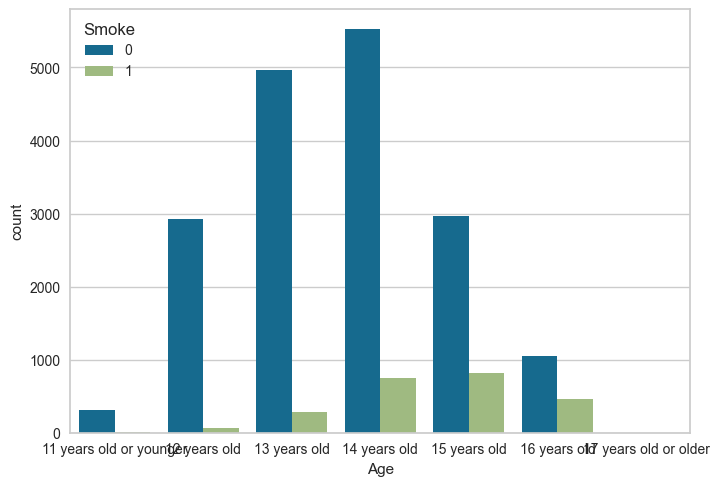

In [54]:
import seaborn as sns

# count smokers and non-smokers by age
sns.countplot(x='Age', hue='Smoke', data=merged_df)


In [55]:
# model = ExtraTreesClassifier(model)

pd.DataFrame({'Feature': pc.get_config('X_train').columns, 'Value' : abs(model.feature_importances_)}).sort_values(by='Value', ascending=False)

AttributeError: 'LinearDiscriminantAnalysis' object has no attribute 'feature_importances_'

Samples  Accuracy       AUC    Recall  \
Age                     Gender                                         
11 years old or younger 1           51  0.960784       0.5       0.0   
                        2           48    0.9375       0.5       0.0   
12 years old            1          409   0.98044       0.5       0.0   
                        2          490  0.983673       0.5       0.0   
13 years old            1          735  0.946939       0.5       0.0   
                        2          846  0.925532       0.5       0.0   
14 years old            1          904  0.886062  0.603178  0.231481   
                        2         1016   0.86811  0.569759  0.166667   
15 years old            1          541  0.852126  0.681044  0.394495   
                        2          572  0.816434  0.675737  0.433333   
16 years old            1          235  0.782979  0.699219  0.472973   
                        2          199   0.80402  0.714432  0.518519   
17 years old or older   1           43  0.674419  0.691886  0.541667   
                        2           22  0.818182     0.825       0.9   

                               Precision        F1     Kappa       MCC  \
Age                     Gender                                           
11 years old or younger 1            0.0       0.0       0.0       0.0   
                        2            0.0       0.0       0.0       0.0   
12 years old            1            0.0       0.0       0.0       0.0   
                        2            0.0       0.0       0.0       0.0   
13 years old            1            0.0       0.0       0.0       0.0   
                        2            0.0       0.0       0.0       0.0   
14 years old            1       0.555556  0.326797  0.275911  0.307739   
                        2       0.478261  0.247191  0.193001  0.225619   
15 years old            1       0.754386  0.518072  0.440682  0.473052   
                        2        0.58427  0.497608  0.388316  0.394808   
16 years old            1       0.744681  0.578512  0.442013  0.462661   
                        2       0.682927  0.589474  0.463908  0.471497   
17 years old or older   1         0.8125      0.65  0.367647  0.394288   
                        2           0.75  0.818182  0.639344      0.65   

                               Selection Rate  
Age                     Gender                 
11 years old or younger 1                 0.0  
                        2                 0.0  
12 years old            1                 0.0  
                        2                 0.0  
13 years old            1                 0.0  
                        2                 0.0  
14 years old            1            0.049779  
                        2            0.045276  
15 years old            1             0.10536  
                        2            0.155594  
16 years old            1                 0.2  
                        2             0.20603  
17 years old or older   1            0.372093  
                        2            0.545455

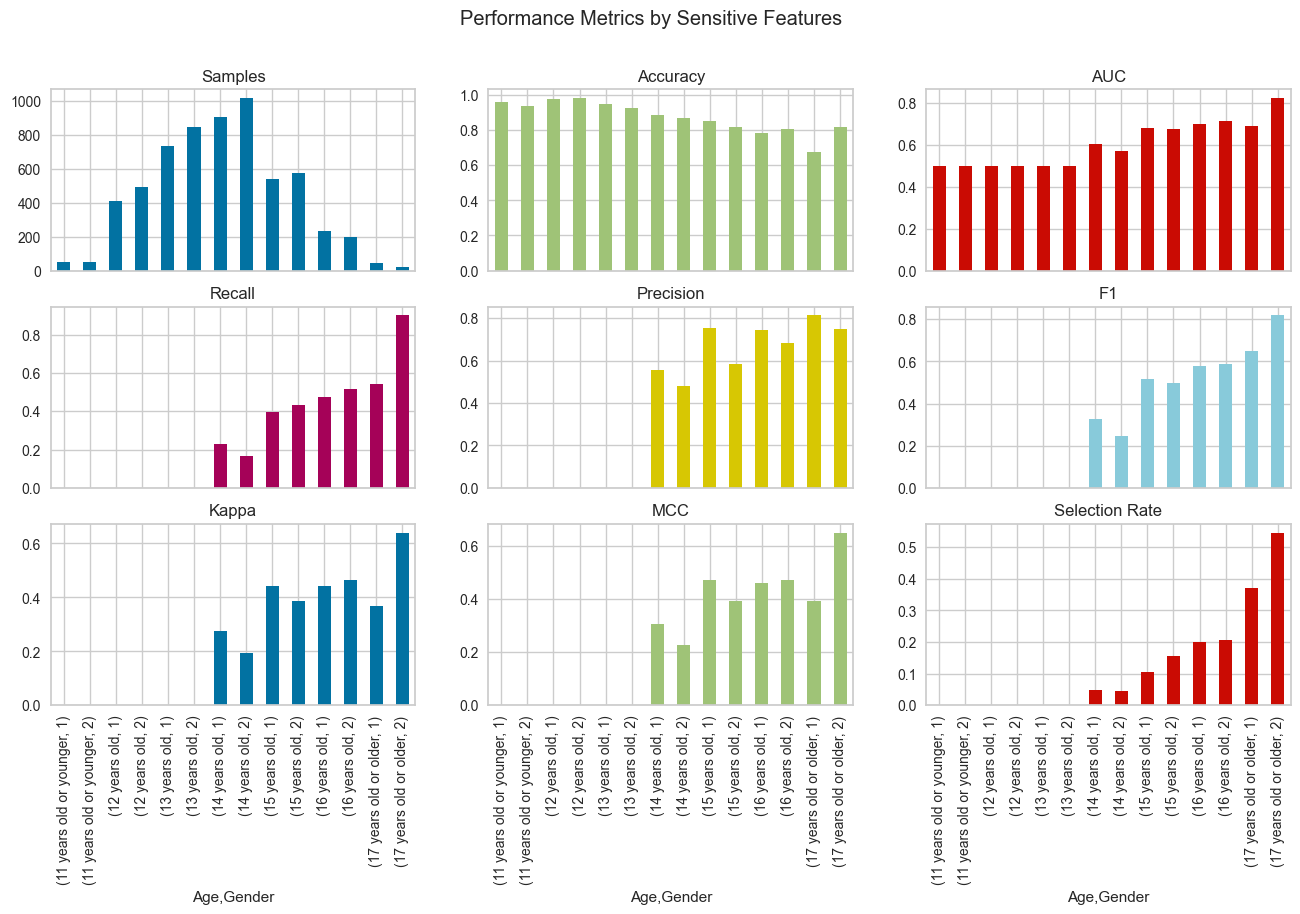

In [8]:
pc.check_fairness(model, sensitive_features = ['Age', "Gender"])